# Tarea 1: Procesamiento de Lenguaje Natural

Integrantes:

* Sebastián Alday (Rut: 18294095-K)
* Paula Canales G. (Rut: 18845155-1)
* Álvaro Neira R. (Rut: 13757209-5)
* Matias Rodriguez U. (Rut: 18362815-1)

# Introducción

En el siguiente documento se describe la tarea 1 para el curso Procesamiento de Lenguaje Natural del Diplomado Inteligencia Artificial Primavera 2021.

El objetivo es visualizar y predecir las derivaciones de los médicos de los servicios primarios de salud (CESFAM) en base a la sospecha diagnóstica. Se dispone de una base de datos de la lista de espera entre 2012 y 2017 para la región de Aysen (datos obtenidos vía ley de transparencia).

Para el desarrollo de este trabajo se utilizaron técnicas de limpieza de datos, análisis no supervisado, visualización y análisis supervisado.

# Carga de módulos, bibliotecas e información necesaria

Importación de librerías.

In [1]:
import pandas as pd
import re
import spacy
import nltk
import sklearn
import wordcloud
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import json
import gc
from sklearn.model_selection import train_test_split


Descarga de los datos.

In [2]:
!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/aysen.csv
!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/aysen_corto.csv
!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/proveedoresA.txt
!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/other_vhosts_access.log
nltk.download('stopwords')
nltk.download('wordnet')
!python -m spacy download es_core_news_sm
import es_core_news_sm
nlp_es = es_core_news_sm.load()

--2021-12-05 00:16:19--  https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/aysen.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29482924 (28M) [text/plain]
Saving to: ‘aysen.csv’

aysen.csv           100%[===================>]  28.12M  --.-KB/s    in 0.1s    

2021-12-05 00:16:21 (224 MB/s) - ‘aysen.csv’ saved [29482924/29482924]

--2021-12-05 00:16:21--  https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/aysen_corto.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4501 (4.4K) [text/plain]
Sa

# 1. Limpieza de la base de datos

Este capítulo del trabajo consiste en la limpieza de la base de datos de la lista de espera de la Región de Aysén. Se parte utilizando sólo las columnas de sospecha diagnóstica y la prestación a la que se deriva, para luego seleccionar las que tienen una cantidad mayor a 10.000 derivaciones y realizar un preprocesamiento del texto. 

## Carga base de datos Aysén

En primer lugar, se inspecciona la base de datos cargada y luego se seleccionan sólo las columnas "SOSPECHA_DIAG" y "PRESTA_EST". Estas columnas son ingresadas a la variable 'aysen_subset'. 



In [3]:
aysen = pd.read_csv("aysen.csv", sep=";", na_values=["Otro",""])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Inspección del dataframe aysen.csv

In [4]:
aysen.head()

,FECHA_NAC,SEXO,PRESTA_MIN,PLANO,EXTREMIDAD,PRESTA_EST,F_ENTRADA,ESTAB_ORIG,ESTAB_DEST,F_SALIDA,C_SALIDA,E_OTOR_AT,PRESTA_MIN_SALIDA,REGION,COMUNA,SOSPECHA_DIAG
0,1985,2,09-001-0,NaN,NaN,ENDODONCIA,31-12-17,25-301,25-100,NaN,NaN,NaN,NaN,11,11101,Celulitis y absceso de boca
1,1946,1,09-004-0,NaN,NaN,PERIODONCIA,31-12-17,25-301,25-100,NaN,NaN,NaN,NaN,11,11101,Periodontitis cronica
2,1937,2,09-006-0,NaN,NaN,REHABILITACION: PROTESIS REMOVIBLE,31-12-17,25-301,25-100,2018-01-03 00:00:00,1.0,25-100,09-006-0,11,11101,Otras afecciones especificadas de los dientes ...
3,1955,2,07-208-0,NaN,NaN,NEUROCIRUGIA,30-12-17,25-300,25-100,NaN,NaN,NaN,NaN,11,11101,"Trastornos de disco lumbar y otros, con radicu..."
4,1997,2,09-001-0,NaN,NaN,ENDODONCIA,30-12-17,25-301,25-100,NaN,NaN,NaN,NaN,11,11101,Celulitis y absceso de boca


Selección de las columnas "SOSPECHA_DIAG" (sospecha diagnóstica) y "PRESTA_EST" (prestación).

In [5]:
aysen_subset = aysen[["SOSPECHA_DIAG","PRESTA_EST"]]

In [6]:
aysen_subset.head()

,SOSPECHA_DIAG,PRESTA_EST
0,Celulitis y absceso de boca,ENDODONCIA
1,Periodontitis cronica,PERIODONCIA
2,Otras afecciones especificadas de los dientes ...,REHABILITACION: PROTESIS REMOVIBLE
3,"Trastornos de disco lumbar y otros, con radicu...",NEUROCIRUGIA
4,Celulitis y absceso de boca,ENDODONCIA


## 1.1 Derivaciones mayores a 10.000 - D10K 

En el presente apartado se cuentas las derivaciones a cada especialidad y se realiza un ránking con ellas.

Se calcula el dataframe D10K que contiene las prestaciones con más de 10.000 valores. Las especialidades se muestran de forma individual. 

In [7]:
D10K_rank = pd.DataFrame(aysen_subset.PRESTA_EST.value_counts(dropna=False))
D10K_rank = D10K_rank.loc[D10K_rank["PRESTA_EST"] > 10000]
D10K_rank = D10K_rank.reset_index()
D10K_rank.columns = ["PRESTA_EST", "PRESTA_EST_COUNT"]
D10K_rank


,PRESTA_EST,PRESTA_EST_COUNT
0,TRAUMATOLOGIA,24004
1,OFTALMOLOGIA,21482
2,CIRUGIA ADULTO,17321
3,OTORRINOLARINGOLOGIA,13663
4,NEUROLOGIA,12316
5,MEDICINA INTERNA,11408
6,GINECOLOGIA,10871
7,ENDODONCIA,10225


In [8]:
list(D10K_rank.PRESTA_EST)

['TRAUMATOLOGIA',
 'OFTALMOLOGIA',
 'CIRUGIA ADULTO',
 'OTORRINOLARINGOLOGIA',
 'NEUROLOGIA',
 'MEDICINA INTERNA',
 'GINECOLOGIA',
 'ENDODONCIA']

In [9]:
D10K = pd.merge(aysen_subset, D10K_rank["PRESTA_EST"], on="PRESTA_EST", how='right')

In [10]:
D10K

,SOSPECHA_DIAG,PRESTA_EST
0,"Osteomielitis, no especificada",TRAUMATOLOGIA
1,Herida de la muñeca y de la mano,TRAUMATOLOGIA
2,Otros trastornos de los meniscos,TRAUMATOLOGIA
3,Esguinces y torceduras de otros sitios y de lo...,TRAUMATOLOGIA
4,Contractura muscular,TRAUMATOLOGIA
...,...,...
121285,Consulta no Especificada,ENDODONCIA
121286,Consulta no Especificada,ENDODONCIA
121287,Consulta no Especificada,ENDODONCIA
121288,Consulta no Especificada,ENDODONCIA


## 1.2 Normalización del texto

A continuación, se construyen las expresiones regulares necesarias para:
- Eliminar signos de puntuación.
- Cambiar todo el texto a minúsculas.
- Cambiar cualquier símbolo no-ASCII.

In [11]:
pattern = r"""(?x)                   # set flag to allow verbose regexps
              (?:[A-Z]\.)+           # abbreviations, e.g. U.S.A.
              |\$?\d+(?:[.,]\d+)?%?  # numbers, incl. currency and percentages
              |\w+(?:[-']\w+)*       # words w/ optional internal hyphens/apostrophe
              |(?:[+/\-@&*¡!.,])     # special characters with meanings
            """

def normalizer(text, remove_tildes = True): #normalizes a given string to lowercase and changes all vowels to their base form
    text = text.lower() #string lowering
    text = re.sub(r'[^A-Za-zñáéíóú]', ' ', text) #replaces every punctuation with a space
    text = nltk.regexp_tokenize(text, pattern)
    text = ' '.join(text)
    if remove_tildes:
        text = re.sub('á', 'a', text) #replaces special vowels to their base forms
        text = re.sub('é', 'e', text)
        text = re.sub('í', 'i', text)
        text = re.sub('ó', 'o', text)
        text = re.sub('ú', 'u', text)
    return text

In [12]:
D10K["SOSPECHA_DIAG"].iloc[5]

'Dorsalgia, (otras dorsopatias)'

In [13]:
normalizer(D10K["SOSPECHA_DIAG"].iloc[5], remove_tildes=True)

'dorsalgia otras dorsopatias'

In [14]:
D10K['SOSPECHA_DIAG_NORM'] = D10K.apply(lambda x: normalizer(x.SOSPECHA_DIAG), axis=1)

In [15]:
D10K

,SOSPECHA_DIAG,PRESTA_EST,SOSPECHA_DIAG_NORM
0,"Osteomielitis, no especificada",TRAUMATOLOGIA,osteomielitis no especificada
1,Herida de la muñeca y de la mano,TRAUMATOLOGIA,herida de la muñeca y de la mano
2,Otros trastornos de los meniscos,TRAUMATOLOGIA,otros trastornos de los meniscos
3,Esguinces y torceduras de otros sitios y de lo...,TRAUMATOLOGIA,esguinces y torceduras de otros sitios y de lo...
4,Contractura muscular,TRAUMATOLOGIA,contractura muscular
...,...,...,...
121285,Consulta no Especificada,ENDODONCIA,consulta no especificada
121286,Consulta no Especificada,ENDODONCIA,consulta no especificada
121287,Consulta no Especificada,ENDODONCIA,consulta no especificada
121288,Consulta no Especificada,ENDODONCIA,consulta no especificada


## 1.3. Stopwords

<font color='red'>**No entendí muy bien por qué se hizo esta unión de palabras que no están en común en la lista. Yo lo cambiaré y simplemente utilizaré simplemente la unión de las dos listas. +1 de Alvaro.**</font>

En primer lugar, se escoge la lista de stopwords a utilizar. En este caso se eligen dos listas de stopwords: nltk y spacy. Se importan las dos listas de stopwords y luego se realiza una unión de los dos conjutos de palabras. 

In [16]:
nltk_stopwords = nltk.corpus.stopwords.words('spanish')
spacy_stopwords = spacy.lang.es.stop_words.STOP_WORDS

stop_words = set(list(nltk_stopwords) + list(spacy_stopwords))
stop_words = list(stop_words)

In [17]:
print(random.sample(stop_words,10))

['estará', 'vosotras', 'mis', 'estarás', 'sois', 'verdadero', 'hasta', 'asi', 'haciendo', 'del']


El conjunto de stopwords debe ser normalizado de la misma forma en que se normalizó el texto de la sospecha diagnóstica. Luego de esta normalización se eliminan los stopwords de la columna "SOSPECHA_DIAG_NORM" en D10K. 

In [18]:
stopwords_normalized = [normalizer(word) for word in stop_words]

def no_stopwords(text):
  '''
  Función para eliminar las stopwords de un texto
  '''
  text = text.split(" ")
  text_nosw = []
  for w in range(len(text)):
    if text[w] not in stopwords_normalized:
      text_nosw.append(text[w])
  separator = ' '
  text = separator.join(text_nosw)
  return text

La función descrita anteriormente permite eliminar los stopwords de un texto normalizado. Se presenta un ejemplo de esto:

In [19]:
print(D10K["SOSPECHA_DIAG_NORM"].iloc[1])

herida de la muñeca y de la mano


In [20]:
print(no_stopwords(D10K["SOSPECHA_DIAG_NORM"].iloc[1]))

herida muñeca mano


Se aplica la función para quitar las stopwords a todas las filas de "SOSPECHA_DIAG_NORM" y se guardan en una nueva columna llamada "SOSPECHA_DIAG_NOSTOPWORDS".

In [21]:
D10K['SOSPECHA_DIAG_NOSTOPWORDS'] = D10K.apply(lambda x: no_stopwords(x.SOSPECHA_DIAG_NORM), axis=1)

In [22]:
D10K

,SOSPECHA_DIAG,PRESTA_EST,SOSPECHA_DIAG_NORM,SOSPECHA_DIAG_NOSTOPWORDS
0,"Osteomielitis, no especificada",TRAUMATOLOGIA,osteomielitis no especificada,osteomielitis especificada
1,Herida de la muñeca y de la mano,TRAUMATOLOGIA,herida de la muñeca y de la mano,herida muñeca mano
2,Otros trastornos de los meniscos,TRAUMATOLOGIA,otros trastornos de los meniscos,trastornos meniscos
3,Esguinces y torceduras de otros sitios y de lo...,TRAUMATOLOGIA,esguinces y torceduras de otros sitios y de lo...,esguinces torceduras sitios especificados pie
4,Contractura muscular,TRAUMATOLOGIA,contractura muscular,contractura muscular
...,...,...,...,...
121285,Consulta no Especificada,ENDODONCIA,consulta no especificada,consulta especificada
121286,Consulta no Especificada,ENDODONCIA,consulta no especificada,consulta especificada
121287,Consulta no Especificada,ENDODONCIA,consulta no especificada,consulta especificada
121288,Consulta no Especificada,ENDODONCIA,consulta no especificada,consulta especificada


## 1.4 Stemming del texto

En esta sección se ha escogido realizar stemming del texto mediante la librería nltk SnowballStemmer en español. Para ello se crea primero la función stemming.

In [23]:
stemmer = nltk.stem.SnowballStemmer("spanish")

def stemming(text):
  text = text.split(" ")
  stemmed = []
  for word in text:
    stemmed.append(stemmer.stem(word))
  separator = ' '
  text = separator.join(stemmed)
  return text


Un ejemplo de cómo se comporta es función es el siguiente:

In [24]:
print(stemming(D10K["SOSPECHA_DIAG_NOSTOPWORDS"].iloc[121285]))

consult especific


Se aplica la función stemming a todas las sospechas diagnósticas que ya han sido normalizadas y quitado las stopwords. 

In [25]:
D10K['SOSPECHA_DIAG_STEM'] = D10K.apply(lambda x: stemming(x.SOSPECHA_DIAG_NOSTOPWORDS), axis=1)



# 2. Análisis no-supervisado y visualización



Esta sección corresponde al análisis no-supervisado y de visualización mediante técnicas como WordCloud, TF-IDF y matriz término-documento. El objetivo de este análisis es realizar una primera aproximación a las características de la base de datos de la lista de espera de la Región de Aysén.



## 2.1 *Visualice utilizando wordcloud las palabras más comunes para cada categoría D10K.*


Se crea la función plot_wordcloud_from_specialty, considerando los vectores tfidf en el tamaño de las palabras. Se obtiene una imagen para cada una de las especialidades de derivación. 

In [26]:
tfidf_vectorizer_D10K = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stopwords_normalized,max_df=0.20)
x_D10K = tfidf_vectorizer_D10K.fit_transform(D10K.SOSPECHA_DIAG_NORM)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['pa'] not in stop_words.
  % sorted(inconsistent)


In [27]:
def plot_wordcloud_from_specialty(specialty):
  tfidf_dict = dict(zip(tfidf_vectorizer_D10K.get_feature_names_out(),x_D10K.toarray()[D10K.PRESTA_EST == specialty].mean(0).reshape(-1,)))
  tfidf_dict = {word:val for word,val in tfidf_dict.items() if val > 0}
  wc = wordcloud.WordCloud(width=1600, height=800).generate_from_frequencies(tfidf_dict)
  plt.figure(figsize=(10,5))
  plt.imshow(wc)
  plt.axis("off")
  plt.show()

TRAUMATOLOGIA


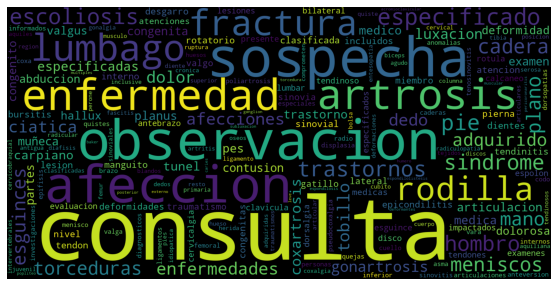


OFTALMOLOGIA


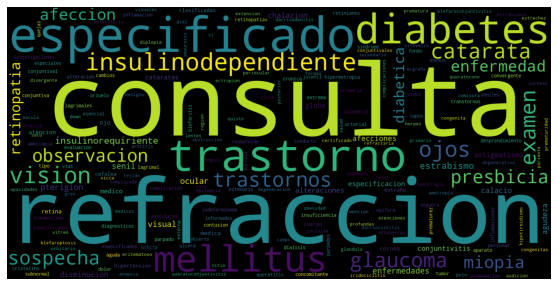


CIRUGIA ADULTO


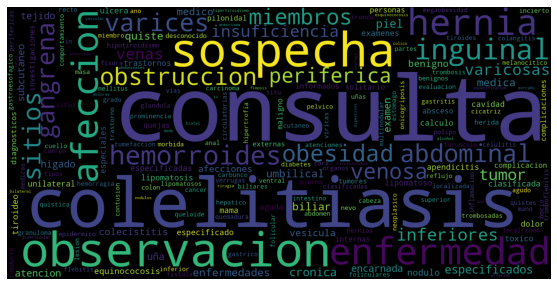


OTORRINOLARINGOLOGIA


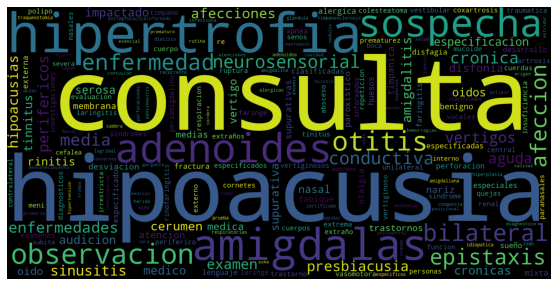


NEUROLOGIA


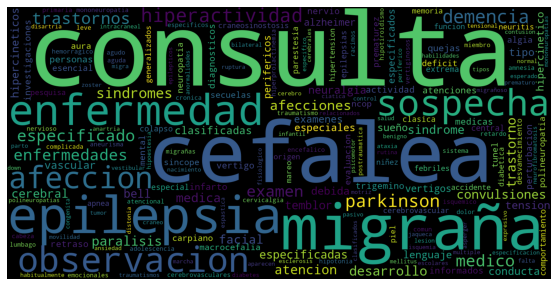


MEDICINA INTERNA


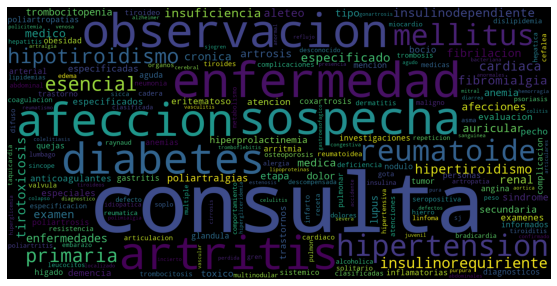


GINECOLOGIA


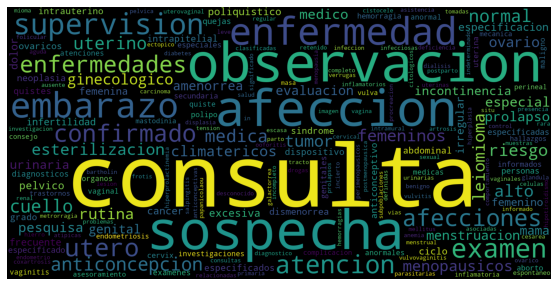


ENDODONCIA


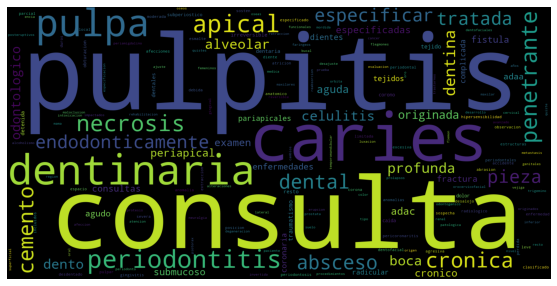

In [28]:
for specialty in list(D10K_rank.PRESTA_EST):
  print(f"{specialty}")
  plot_wordcloud_from_specialty(specialty)
  print(f"")

## 2.2 Matrices término-documento y TF-IDF en D10K

En la presente sección se calculan las matrices término-documento y TF-IDF para el dataframe D10K que ha sido normalizado en la sección 1 de este trabajo. Esto quiere decir que se utiliza la columna "SOSPECHA_DIAG_NORM". 

Se realiza la vectorización TF-IDF mediante el método implementado en sklearn.

In [29]:
tfidf_vectorizer_D10K = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stopwords_normalized,max_df=0.20)
x_D10K = tfidf_vectorizer_D10K.fit_transform(D10K.SOSPECHA_DIAG_NORM)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['pa'] not in stop_words.
  % sorted(inconsistent)


Se imprimen las palabras más comunes y las menos comunes dentro de la columno de Sospecha diagnóstico.

In [30]:
idf_dict = dict(zip(tfidf_vectorizer_D10K.get_feature_names(),tfidf_vectorizer_D10K.idf_))
idf_dict = {k: v for k, v in sorted(idf_dict.items(), key=lambda item: item[1])}
print(list(idf_dict.items())[:5])
print(list(idf_dict.items())[-5:])

[('consulta', 2.649610509341379), ('sospecha', 3.4656604476275823), ('observacion', 3.498812654944483), ('enfermedad', 3.636364961711797), ('afeccion', 3.761789065001313)]
[('xantogranuloma', 12.012800715411773), ('xeroderma', 12.012800715411773), ('xerosis', 12.012800715411773), ('yod', 12.012800715411773), ('yugular', 12.012800715411773)]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Se imprimen las matrices TF-IDF y término-documento.

En este caso, cada documento es una sospecha de diagnóstico. 

Finalmente, se muestra el tamaño de la matriz y el largo del vocabulario.

In [31]:
print(x_D10K) # por defecto el objeto x es una estructura iddoc, idpalabra, tfidf
print(x_D10K.toarray()) # para visualizarlo como matriz hay que utilizar el método scipy.sparse.csr_matrix.toarray()

  (0, 2742)	1.0
  (1, 2294)	0.5199608917525643
  (1, 2516)	0.5731546322487499
  (1, 1762)	0.6333517494881328
  (2, 2367)	0.8209464261655527
  (2, 3726)	0.5710052235890727
  (3, 2926)	0.422613609263217
  (3, 1366)	0.4217680352706118
  (3, 3496)	0.46936786599793645
  (3, 3690)	0.46005577174056433
  (3, 1346)	0.4599477741507418
  (4, 2510)	0.6894985933543911
  (4, 840)	0.7242870216718756
  (5, 1181)	0.7026538567676135
  (5, 1175)	0.7115318387602891
  (6, 1918)	0.6042460091826828
  (6, 1938)	0.5765692514691003
  (6, 1100)	0.5499587790436322
  (7, 3213)	0.5564531149037157
  (7, 1973)	0.512070791376232
  (7, 1287)	0.543709339341195
  (7, 1587)	0.36403789616801296
  (8, 2984)	1.0
  (9, 507)	0.7249918808264069
  (9, 333)	0.6887574121095098
  :	:
  (121270, 575)	0.6055072413496466
  (121271, 829)	1.0
  (121272, 1003)	0.7958397958591545
  (121272, 575)	0.6055072413496466
  (121273, 829)	1.0
  (121274, 3164)	1.0
  (121275, 829)	1.0
  (121276, 2862)	0.622899930756619
  (121276, 1009)	0.59453962524

In [32]:
print(x_D10K.shape) # dimensiones de la matriz
print(len(tfidf_vectorizer_D10K.get_feature_names())) # el tamaño de vocabulario coincide con el número de filas
print(random.sample(tfidf_vectorizer_D10K.get_feature_names(),10))

(121290, 3950)
3950
['dejado', 'anteojos', 'olszewski', 'faciobraquiocrural', 'electrolitos', 'hielo', 'descripciones', 'cortos', 'metatarsus', 'hipertelorismo']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## 2.3 SVD sobre la matriz TF-IDF

En la presente sección se realiza una descomposición SVD sobre la matriz TF-IDF. Con el resultado obtenido se verifica si los temas principales identificados corresponden con las prestaciones médicas a las cuales son derivados dependiendo de la sospecha diagnóstica. 

Se hace la descomposición SVD sobre TF-IDF:

In [33]:
#SVD ~4 minutos
U, s, Vh = np.linalg.svd(x_D10K.toarray(), full_matrices=False)

Además, se recupera el vocabulario correspondiente a la columna "SOSPECHA_DIAG_NORM" del dataframe D10K. Posteriormente, se define la función show_topics, que permite obtner las palabras más representativas de los temas identificados en la descomposición SVD. 

In [34]:
vocab_D10K = tfidf_vectorizer_D10K.get_feature_names()
def show_topics(a):
  num_top_words=8
  top_words_values = lambda t: [f"{vocab_D10K[i]}({str(round(v,3))})" for i,v in zip(np.argsort(t)[:-num_top_words-1:-1],np.sort(t)[:-num_top_words-1:-1])]
  topic_words_values = ([top_words_values(t) for t in a])
  return [' '.join(t) for t in topic_words_values]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Mediante la función show_topics se muestran los primeros 8 tópicos identificados. A partir de estos tópicos se pueden obtener las siguientes conclusiones.

- Existen palabras que se repiten en distintos temas y que no representan ninguna derivación, como "consulta", "receta", "especificado" o "trastorno". 
- Se observan temas que sí pueden ser identificados como una derivación. Por ejemplo, es el caso del quinto y sexto tema. El quinto se puede categorizar como Endodoncia con palabras como "pulpitis", "periodontitis", "apical". El sexto tema se identifica como Medicina Interna, teniendo palabras como "mellitus", "insulinodependiente", "diabetes". El primer tema se podría catalogar como Ginecología y el cuarto como Traumatología, aunque no se puede decir tan claramente por la alta cantidad de palabras comunes. 
- Existen temas que son combinaciones de dos especialidades de derivación. Es el caso del tema 2 (combinación Ginecología y Trumatología), tema 3 (Oftalmología y Traumatología), tema 7 (Oftalmología, Endodoncia y Otorrinolaringología) y tema 8 (Oftalmología y Endodoncia).
- Este experimento evidencia la necesidad de utilizar "stop words médicas", específicas a este conjunto de datos. 


In [35]:
# palabras y valores asociados a los tópicos
show_topics(Vh)[:8]

['consulta(1.0) receta(0.0) repeticion(0.0) sexual(0.0) vigilancia(0.0) asesoria(0.0) abuso(0.0) niños(0.0)',
 'consulta(0.0) abortos(0.0) pseudocoxalgia(0.0) sialolitiasis(0.0) metatarsalgia(0.0) fetales(0.0) polidactilia(0.0) subacromial(0.0)',
 'especificado(0.589) refraccion(0.581) trastorno(0.553) trastornos(0.067) lumbago(0.062) estrabismo(0.024) interno(0.017) rodilla(0.014)',
 'refraccion(0.0) trastorno(0.0) enfermedad(0.0) afeccion(0.0) especificado(0.0) observacion(0.0) trastornos(0.0) lumbago(0.0)',
 'pulpitis(0.997) especificar(0.082) irreversible(0.003) reversible(0.0) cronica(0.0) periodontitis(0.0) apical(0.0) insuficiencia(0.0)',
 'refraccion(0.0) trastorno(0.0) trastornos(0.0) mellitus(0.0) insulinodependiente(0.0) diabetes(0.0) afeccion(0.0) enfermedad(0.0)',
 'examen(0.73) medico(0.454) vision(0.361) ojos(0.353) odontologico(0.033) especial(0.03) oidos(0.027) audicion(0.027)',
 'examen(0.001) medico(0.001) vision(0.0) ojos(0.0) afeccion(0.0) enfermedad(0.0) odontolog

## 2.4 Visualización alternativa: Cruz Roja

Se incluye la visualización con el símbolo de la Cruz Roja.

In [ ]:
import PIL

In [ ]:
def plot_redcross_from_specialty(specialty):
  tfidf_dict = dict(zip(tfidf_vectorizer_D10K.get_feature_names_out(),x_D10K.toarray()[D10K.PRESTA_EST == specialty].mean(0).reshape(-1,)))
  tfidf_dict = {word:val for word,val in tfidf_dict.items() if val > 0}
  mask = np.array(PIL.Image.open("swiss-cross-2-plus-cross-pattern-minimal-geometric-pattern-saltire-black-studio-grafiikka.jpg"))
  wc = wordcloud.WordCloud(width=800, height=800, mask=mask, background_color="white",color_func=lambda *args, **kwargs: "red").generate_from_frequencies(tfidf_dict)
  plt.figure(figsize=(10,5))
  plt.imshow(wc)
  plt.axis("off")
  plt.show()

In [ ]:
for specialty in list(D10K_rank.PRESTA_EST):
  print(f"{specialty}")
  plot_redcross_from_specialty(specialty)
  print(f"")

TRAUMATOLOGIA

OFTALMOLOGIA

CIRUGIA ADULTO

OTORRINOLARINGOLOGIA

NEUROLOGIA

MEDICINA INTERNA

GINECOLOGIA

ENDODONCIA



*   Liberar memoria que no se va a utilizar:

In [36]:
U = None
s = None
Vh = None
gc.collect()

18221

# 3. Análisis supervisado

## 3.1 Probabilidad de cada categoría en D10K

Para calcular la probabilidad de cada categoría en D10K, primero obtendremos el total de categorías para luego dividir la cuenta de categoría por el total. Asignaremos una nueva columna en el dataframe para la probabilidad.

In [37]:
total_cat = D10K_rank.PRESTA_EST_COUNT.sum()
D10K_rank['PROB'] = D10K_rank.PRESTA_EST_COUNT/total_cat
D10K_rank

,PRESTA_EST,PRESTA_EST_COUNT,PROB
0,TRAUMATOLOGIA,24004,0.197906
1,OFTALMOLOGIA,21482,0.177113
2,CIRUGIA ADULTO,17321,0.142806
3,OTORRINOLARINGOLOGIA,13663,0.112647
4,NEUROLOGIA,12316,0.101542
5,MEDICINA INTERNA,11408,0.094056
6,GINECOLOGIA,10871,0.089628
7,ENDODONCIA,10225,0.084302


## 3.2 Diccionario P(palabra|categoria).

En esta sección se construirá un diccionario, donde para cada palabra se obtendrá la probabilidad P(palabra|categoria).
[IMAGEN]

Primero dividiremos la data de D10K en entrenamiento y test (90% y 10% respectivamente)

In [38]:
train, test = train_test_split(D10K, test_size=0.1)

A continuación, se construye el vector en base a los datos de entrenamiento quitando los stop_words

In [39]:
count_vectorizer = sklearn.feature_extraction.text.CountVectorizer(stop_words=stop_words)
term_doc_matrix_train = count_vectorizer.fit_transform(train.SOSPECHA_DIAG)
term_doc_matrix_train

<109161x4265 sparse matrix of type '<class 'numpy.int64'>'
	with 303403 stored elements in Compressed Sparse Row format>

Luego, se calcula la probabilidad de cada palabra por categoría

In [40]:
p_w_category = {}
p_w_s_category = {}
for index, row in D10K_rank.iterrows():
  category = row.PRESTA_EST
  count_c = np.asarray(term_doc_matrix_train.todense()[train.PRESTA_EST == category,:].sum(0)).reshape(-1).sum()
  # Se obtienen las apariciones de cada una de las palabras en cada clase
  c_w = np.asarray(term_doc_matrix_train.todense()[train.PRESTA_EST == category,:].sum(0)).reshape(-1)
  # Se calcula la probabilidad normal
  p_w = c_w / count_c
  # Se calcula la probabilidad suavizada para bayes
  vocab = len(np.asarray(term_doc_matrix_train.todense()[train.PRESTA_EST == category,:].sum(0)).reshape(-1))
  p_w_smoothing = (c_w + 1) / (count_c + vocab)
  
  p_w_category[category] = dict(zip(count_vectorizer.get_feature_names_out(), p_w))
  p_w_s_category[category] = dict(zip(count_vectorizer.get_feature_names_out(), p_w_smoothing))

En la siguiente celda se muestran las primeras 10 palabras con mayor probabilidad de cada clase del D10K

In [41]:
for category in p_w_category:
  print(category) 
  prob = p_w_category[category]
  better_prob = {k: prob[k] for k in sorted(prob, key=prob.get, reverse=True)[:10]}
  print(json.dumps(better_prob,indent=4))

TRAUMATOLOGIA
{
    "especificada": 0.1024276541472425,
    "consulta": 0.058081918667722165,
    "sospecha": 0.032661916908552496,
    "observacion": 0.0313278799073504,
    "enfermedad": 0.0255812589790952,
    "artrosis": 0.025507960242765415,
    "afeccion": 0.025009528835722872,
    "fractura": 0.01979065880904213,
    "rodilla": 0.016609493652329433,
    "trastornos": 0.016155041487084763
}
OFTALMOLOGIA
{
    "especificada": 0.08628423040604344,
    "especificado": 0.061004878816493545,
    "trastorno": 0.05301778407302487,
    "consulta": 0.05004721435316336,
    "diabetes": 0.04792256846081209,
    "mellitus": 0.04774551463644948,
    "refraccion": 0.04040761724897702,
    "insulinodependiente": 0.02925322631413283,
    "examen": 0.026872836008813347,
    "vision": 0.02647938306578533
}
CIRUGIA ADULTO
{
    "especificada": 0.12036311389759666,
    "consulta": 0.07281870428422152,
    "colelitiasis": 0.03822709857192616,
    "sospecha": 0.03178335074886799,
    "observacion": 0.

Se observa que entre las palabras con mayor probabilidad de cada categoría, se encuentran palabras que tienen si sentido como por ejemplo: 


*   TRAUMATOLOGIA: artrosis, fractura, rodilla.
*   ENDODONCIA: pulpitis, pulpa, absceso.
*   CIRUGIA ADULTO: hernia, tumor.

Pero también hay palabras genéricas que están presentes y con alta probabilidad en todas las clases, como: 


*   especificada.
*   especificado.
*   consulta.

Se sugiere que para mejorar los resultados estas palabras sean quitadas de la data.

## 3.3 *Construya un clasificador Bayesiano Naive. Reporte el resultado de 3 métricas de clasificación ¿Detecto alguna categoría de mayor dificultad? ¿puede sugerir alguna interpretación a su resultado?*


In [42]:
for name, values in train.iteritems():
  if name not in ['PRESTA_EST', 'SOSPECHA_DIAG']:
    train.drop(name, axis=1, inplace=True)

for name, values in test.iteritems():
  if name not in ['PRESTA_EST', 'SOSPECHA_DIAG']:
    test.drop(name, axis=1, inplace=True)

In [43]:
def binary_naive_bayes(count_vectorizer, train_matrix, specialty):
  c_w_negative = np.asarray(train_matrix.todense()[train.PRESTA_EST != specialty, :].sum(0)).reshape(-1)
  c_w_positive = np.asarray(train_matrix.todense()[train.PRESTA_EST == specialty, :].sum(0)).reshape(-1)
  c_negative = (train.PRESTA_EST != specialty).sum()
  c_positive = (train.PRESTA_EST == specialty).sum()
  p_w_negative = (c_w_negative + 1) / c_negative # Probabilidad asociada a cada palabra en la clase negativa
  p_w_positive = (c_w_positive + 1) / c_positive
  r = np.log(p_w_positive / p_w_negative)
  term_doc_matrix_test = count_vectorizer.transform(test.SOSPECHA_DIAG)
  test_pred = term_doc_matrix_test.dot(r) > 0
  test_label = np.where(test.PRESTA_EST == specialty, True, False)
  confusion_matrix = pd.crosstab(test_label,test_pred)
  TP = confusion_matrix[1][1]
  FP = confusion_matrix[1][0]
  FN = confusion_matrix[0][1]
  accuracy = (np.array(confusion_matrix).diagonal().sum() / np.array(confusion_matrix).sum())
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  return accuracy, precision, recall

In [44]:
for specialty in list(D10K_rank.PRESTA_EST):
  accuracy, precision, recall = binary_naive_bayes(count_vectorizer, term_doc_matrix_train, specialty)
  print(f"specialty: {specialty}: accuracy={accuracy}, precision={precision}, recall={recall}")

specialty: TRAUMATOLOGIA: accuracy=0.8551405721823728, precision=0.6115131578947368, recall=0.7634496919917865
specialty: OFTALMOLOGIA: accuracy=0.9112045510759337, precision=0.7405913978494624, recall=0.7684797768479776
specialty: CIRUGIA ADULTO: accuracy=0.7150630719762553, precision=0.32808398950131235, recall=0.9269823160296634
specialty: OTORRINOLARINGOLOGIA: accuracy=0.9166460549097205, precision=0.6182026330852891, recall=0.7584269662921348
specialty: NEUROLOGIA: accuracy=0.830736251958117, precision=0.34002229654403565, recall=0.7676174496644296
specialty: MEDICINA INTERNA: accuracy=0.6749938164729161, precision=0.2110356186946675, recall=0.9030837004405287
specialty: GINECOLOGIA: accuracy=0.6874433176683981, precision=0.21356993736951985, recall=0.9770773638968482
specialty: ENDODONCIA: accuracy=0.9614147909967846, precision=0.7519230769230769, recall=0.7883064516129032


*   Liberar memoria que no se va a utilizar:

In [45]:
count_vectorizer = None
term_doc_matrix_train = None
gc.collect()

88

## 3.4 *¿Cómo varía su resultado al utilizar bigramas?*



In [46]:
count_vectorizer_bigrams = sklearn.feature_extraction.text.CountVectorizer(stop_words=stop_words, ngram_range=(1, 2))
term_doc_matrix_train_bigrams = count_vectorizer_bigrams.fit_transform(train.SOSPECHA_DIAG)

In [47]:
for specialty in list(D10K_rank.PRESTA_EST):
  accuracy, precision, recall=binary_naive_bayes(count_vectorizer_bigrams, term_doc_matrix_train_bigrams, specialty)
  print(f"specialty (with bigrams): {specialty}: accuracy={accuracy}, precision={precision}, recall={recall}")

specialty (with bigrams): TRAUMATOLOGIA: accuracy=0.8520075851265562, precision=0.6028938906752411, recall=0.7700205338809035
specialty (with bigrams): OFTALMOLOGIA: accuracy=0.9122763624371342, precision=0.7438313144908031, recall=0.7708042770804278
specialty (with bigrams): CIRUGIA ADULTO: accuracy=0.7158875422541018, precision=0.3291624621594349, recall=0.930405019965773
specialty (with bigrams): OTORRINOLARINGOLOGIA: accuracy=0.9103800807980872, precision=0.5910318746623446, recall=0.7682584269662921
specialty (with bigrams): NEUROLOGIA: accuracy=0.8248000659576222, precision=0.33297529538131043, recall=0.7802013422818792
specialty (with bigrams): MEDICINA INTERNA: accuracy=0.6670789018055899, precision=0.20929301021430002, recall=0.920704845814978
specialty (with bigrams): GINECOLOGIA: accuracy=0.6809300024734108, precision=0.2105802747590732, recall=0.9808978032473734
specialty (with bigrams): ENDODONCIA: accuracy=0.9546541347184434, precision=0.696969696969697, recall=0.78830645